In [24]:
# Libraries
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import requests
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time

In [25]:
#GPU Checking
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("GPU is not available. Using CPU.")

Using GPU: NVIDIA GeForce RTX 3060


In [26]:
# Grabbed the dataloader from the GitHub

# Step 1: Download the dataset
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = requests.get(url)
text = response.text  # This is the entire text data

# Step 2: Prepare the dataset
sequence_length = 50
# Create a character mapping to integers
chars = sorted(list(set(text)))
char_to_int = {ch: i for i, ch in enumerate(chars)}
int_to_char = {i: ch for i, ch in enumerate(chars)}

# Encode the text into integers
encoded_text = [char_to_int[ch] for ch in text]

# Create sequences and targets
sequences = []
targets = []
for i in range(0, len(encoded_text) - sequence_length):
    seq = encoded_text[i:i+sequence_length]
    target = encoded_text[i+sequence_length]
    sequences.append(seq)
    targets.append(target)

# Convert lists to PyTorch tensors
sequences = torch.tensor(sequences, dtype=torch.long)
targets = torch.tensor(targets, dtype=torch.long)

# Step 3: Create a dataset class
class CharDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, index):
        return self.sequences[index], self.targets[index]

# Instantiate the dataset
dataset = CharDataset(sequences, targets)

# Step 4: Create data loaders
batch_size = 128
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

In [27]:
#Training Loop + Empty Arrays for storing Training and Validation Results
train_loss_list = []
val_loss_list = []
val_accuracy_list = []
all_predicted = []
all_labels = []

def TL(n_epochs, optimizer, model, loss_fn, training_loader, valid_loader):
  for epoch in range(1, n_epochs + 1):
    loss_train = 0.0
    model.train()
    for Stacked_images, labels in training_loader:
      Stacked_images = Stacked_images.to(device)
      labels = labels.to(device)
      outputs = model(Stacked_images)
      loss = loss_fn(outputs, labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      loss_train += loss.item()
    train_loss_list.append(loss_train / len(training_loader)) 

    
    #Validation Loop
    correct = 0
    total = 0
    valid_loss = 0.0
    model.eval()
    with torch.no_grad():
      for inputs, labels in valid_loader:
          inputs = inputs.to(device)
          labels = labels.to(device)
          outputs = model(inputs)
          loss = loss_fn(outputs, labels)
          valid_loss += loss.item()
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          all_predicted.extend(predicted.cpu().numpy())
          all_labels.extend(labels.cpu().numpy())

    val_loss_list.append(valid_loss / len(valid_loader))
    val_accuracy = correct / total
    val_accuracy_list.append(val_accuracy)

    if epoch == 1 or epoch % 5 == 0: 
      print('Epoch: {}, Training Loss: {}, Validation Loss: {}, Validation Acc: {}'.format(epoch, loss_train / len(training_loader), valid_loss / len(valid_loader), val_accuracy))


Problem 2 - Part B: GRU

In [28]:
# GRU Model
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size 
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.GRU(hidden_size, hidden_size, num_layers= num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.lstm(embedded)
        output = self.fc(output[:, -1, :])
        return output

In [29]:
hidden_size = 128
model = GRU(len(chars), hidden_size, len(chars), 1).to(device)
a = 0.01
epochs = 20
lossFN = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr= a)
training_loader = train_loader
valid_loader = test_loader
start_time = time.time()

TL(
  n_epochs= epochs,
  optimizer= optimizer,
  model= model,
  loss_fn= lossFN,
  training_loader= training_loader,
  valid_loader= valid_loader
)

#Getting the time
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken: {elapsed_time/60} Minutes")

Epoch: 1, Training Loss: 2.679291328786094, Validation Loss: 2.3810150821661717, Validation Acc: 0.3314759609996638
Epoch: 5, Training Loss: 1.99273835556027, Validation Loss: 1.9714747187876525, Validation Acc: 0.4241846912473383
Epoch: 10, Training Loss: 1.8140015060950885, Validation Loss: 1.8105214282280402, Validation Acc: 0.465152975456685
Epoch: 15, Training Loss: 1.7154228331812893, Validation Loss: 1.717343010029708, Validation Acc: 0.49062871231648547
Epoch: 20, Training Loss: 1.647668368913494, Validation Loss: 1.6572538086961757, Validation Acc: 0.5079547237476185
Time taken: 5.095984959602356 Minutes


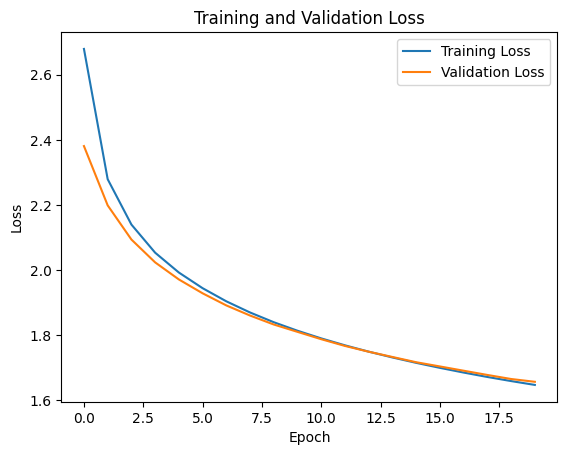

In [30]:
# Plotting training and validation loss
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
#plt.savefig('temp/LeNet_training_validation_loss.png')
plt.show()

In [31]:
#Complexity
numel_list = [p.numel() for p in model.parameters()]
print("Model Complexity: {}".format(sum(numel_list)))
#sum(numel_list), numel_list

Model Complexity: 115777
